In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing_extensions import List, TypedDict
from langchain_core.prompts import PromptTemplate
from langgraph.graph import START, StateGraph, END
import smtplib
from email.message import EmailMessage


load_dotenv()

openrouter_key = os.getenv("OPENROUTER_API_KEY")
openrouter_base_url = os.getenv("OPENAI_BASE_URL")

In [2]:
llm = ChatOpenAI(
    model_name="deepseek/deepseek-chat-v3.1:free",
    api_key=openrouter_key,
    base_url=openrouter_base_url
)


In [3]:
class State(TypedDict):
    Log_entry: str
    answer: str



In [20]:
def classifier(state: State):
    """
    Classifies a log entry as 'critical' or 'not critical' using an LLM."""

    log_entry = state["Log_entry"]
    if not log_entry:
        return {"classification": "error", "answer": "No log entry provided."}

    template = """You are a log analysis expert. Your task is to classify a log entry as either 'critical' 
            or 'not critical'. Provide a brief, one-sentence reason for your classification.\n\n
            Log Entry: {Log_entry}\n\n
            Classification: """
    

    formatted_prompt = template.format(Log_entry=log_entry)
    response = llm.invoke(formatted_prompt)
    return {"Log_entry": log_entry, "answer": response.content}


def responder(state: State):
    """
    Responds to classifier output:
    - If critical -> append the log entry to the given file.
    - If not critical -> end silently.
    """
    
    classification = state["answer"].lower()
    log_entry = state["Log_entry"]

    if not classification:
        return {"status": "error", "message": "No classification found."}

    prompt = f"""
            You are given the full output of a classifier. 
            Your task is to decide if the classification is 'critical' or 'not critical'.

            The output may contain explanations, but only the classification matters. 
            If the classifier says "not critical", you must respond with exactly: not critical.
            If the classifier says "critical", you must respond with exactly: critical.

            Classifier Output:
            {classification}

            Answer with one word only: "critical" or "not critical".
            """

    res = llm.invoke(prompt).content.strip().lower()

    if res == "critical":
        msg = EmailMessage()
        msg.set_content(f"""
            ALERT : CRITICAL
                        
            Critical Log:       
            {log_entry}                 
            Classification Result:
            {classification}
                        """)

        msg['Subject'] = "Critical Alert: LLM Classification"
        msg['From'] = "41276@students.riphah.edu.pk"
        msg['To'] = "40855@students.riphah.edu.pk"
        s = smtplib.SMTP("smtp.gmail.com", 587)
        s.starttls()
        s.login("bilalahmad101325@gmail.com", "bdhl zzxq gjzq byda")
        s.send_message(msg)
        s.quit()
    else:
        print("Non critical")    
    


   

In [21]:
graph_builder = StateGraph(State)

graph_builder.add_node("Classifier", classifier)
graph_builder.add_node("Responder", responder)

graph_builder.add_edge(START, "Classifier")
graph_builder.add_edge("Classifier", "Responder")
graph_builder.add_edge("Responder", END)
graph = graph_builder.compile()



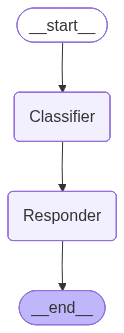

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
result = graph.invoke({"Log_entry": "<13>1 2025-09-10T15:24:03Z firewall.corp.net FW_DENY 10.10.10.1 src_port=54321 dest_ip=172.16.1.10 dest_port=22 protocol=6 reason=\"Port Scan\" rule_id=100 action=\"deny\" "})
print(result)

{'Log_entry': '<13>1 2025-09-10T15:24:03Z firewall.corp.net FW_DENY 10.10.10.1 src_port=54321 dest_ip=172.16.1.10 dest_port=22 protocol=6 reason="Port Scan" rule_id=100 action="deny" ', 'answer': 'critical\n\nThe log entry indicates a denied port scan attempt on port 22 (SSH), which is a common reconnaissance activity used by attackers to identify vulnerable services and could be a precursor to a more serious attack.'}
